## 1. 설정, 임포트 및 TensorFlow 버전 확인

In [19]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

# --- TensorFlow 버전 확인 및 안내 ---
print(f"현재 사용 중인 TensorFlow 버전: {tf.__version__}")
if tf.__version__ < "2.5.0":
    # Using f''' for the multiline string to ensure it's an f-string and avoid quote clashes.
    # Also, the {tf.__version__} inside this f-string will be evaluated.
    warning_message = f'''
    *********************************************************************************
    경고: 현재 TensorFlow {tf.__version__} 버전을 사용하고 계십니다.
    'AttributeError: module tensorflow.lite.python.schema_py_generated has no attribute Model' 오류는
    주로 이전 TensorFlow 버전(예: 2.4.x) 또는 TensorFlow Lite 설치 문제와 관련이 있습니다.
    원활한 TFLite 호환성을 위해 TensorFlow를 2.5.0 이상 버전으로 업그레이드하는 것을 강력히 권장합니다.

    다음 pip 명령어를 사용하여 업그레이드를 시도할 수 있습니다:
      pip install --upgrade tensorflow

    업그레이드 후에도 오류가 지속되면, 깨끗한 환경에서 TensorFlow를 재설치하는 것을 고려해 보세요:
      pip uninstall tensorflow
      pip install tensorflow
    *********************************************************************************
    '''
    print(warning_message)
# --- TensorFlow 버전 확인 종료 ---

# 재현성을 위한 시드 설정
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


현재 사용 중인 TensorFlow 버전: 2.5.0


## 2. 데이터 로딩 및 'Yes'/'No' 명령어 필터링

In [3]:
data_dir = pathlib.Path("data/mini_speech_commands")
if not data_dir.exists():
    print("mini_speech_commands 데이터셋 다운로드 및 압축 해제 중...")
    tf.keras.utils.get_file(
        "mini_speech_commands.zip",
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir=".", cache_subdir="data")
    print("데이터셋 다운로드 및 압축 해제 완료.")
else:
    print(f"데이터셋이 이미 {data_dir}에 존재합니다.")

TARGET_COMMANDS = ["no", "yes"]
print(f"대상 명령어: {TARGET_COMMANDS}")

all_filenames_str_list = tf.io.gfile.glob(str(data_dir) + "/*/*")
filtered_filenames_str_list = []
for filename_str in all_filenames_str_list:
    if os.path.basename(os.path.dirname(filename_str)) in TARGET_COMMANDS:
        filtered_filenames_str_list.append(filename_str)

if not filtered_filenames_str_list:
    print("오류: 'yes' 또는 'no'에 대한 파일을 찾을 수 없습니다.")
    raise ValueError("오류: 'yes' 또는 'no'에 대한 파일을 찾을 수 없습니다.")

filenames_tensor = tf.random.shuffle(tf.constant(filtered_filenames_str_list, dtype=tf.string), seed=seed)
num_samples = len(filenames_tensor)
print(f"'yes'와 'no' 오디오 파일 총 개수: {num_samples}")

commands = np.array(TARGET_COMMANDS)
num_labels = len(commands)
print(f"모델용 업데이트된 명령어: {commands}")
print(f"업데이트된 레이블 수: {num_labels}")


데이터셋이 이미 data\mini_speech_commands에 존재합니다.
대상 명령어: ['no', 'yes']
'yes'와 'no' 오디오 파일 총 개수: 2000
모델용 업데이트된 명령어: ['no' 'yes']
업데이트된 레이블 수: 2


## 3. 필터링된 데이터셋 분할

In [5]:
if num_samples > 0:
    train_size = int(0.8 * num_samples)
    val_size = int(0.1 * num_samples)
    if num_samples > 0 and val_size == 0 and num_samples > train_size : val_size = 1 
    if num_samples > 0 and train_size == 0 and num_samples > val_size : train_size = 1
    test_size = num_samples - train_size - val_size
    if test_size < 0:
        test_size = 0
        if train_size + val_size > num_samples:
            val_size = num_samples - train_size
            if val_size < 0: val_size = 0; train_size = num_samples
    train_files = filenames_tensor[:train_size]
    val_files = filenames_tensor[train_size : train_size + val_size]
    test_files = filenames_tensor[train_size + val_size:]
else:
    train_files = tf.constant([], dtype=tf.string)
    val_files = tf.constant([], dtype=tf.string)
    test_files = tf.constant([], dtype=tf.string)

print(f"훈련 세트 크기: {len(train_files)}")
print(f"검증 세트 크기: {len(val_files)}")
print(f"테스트 세트 크기: {len(test_files)}")


훈련 세트 크기: 1600
검증 세트 크기: 200
테스트 세트 크기: 200


## 4. 오디오 전처리 함수

In [6]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1)
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]

def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

AUTOTUNE = tf.data.AUTOTUNE


## 5. 스펙트로그램 생성 및 입력 전처리

In [7]:
RESIZE_HEIGHT = 8
RESIZE_WIDTH = 8
TARGET_AUDIO_LEN = 16000

def get_spectrogram(waveform):
    waveform = tf.cast(waveform, tf.float32)
    waveform_padded = tf.pad(waveform, [[0, tf.maximum(0, TARGET_AUDIO_LEN - tf.shape(waveform)[0])]], mode="CONSTANT", constant_values=0)
    equal_length = waveform_padded[:TARGET_AUDIO_LEN]
    equal_length = tf.reshape(equal_length, [TARGET_AUDIO_LEN])
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    return spectrogram

def get_spectrogram_resized_and_label_id(audio, label):
    spectrogram_raw = get_spectrogram(audio)
    spectrogram_expanded = tf.expand_dims(spectrogram_raw, -1)
    spectrogram_resized = tf.image.resize(spectrogram_expanded, [RESIZE_HEIGHT, RESIZE_WIDTH])
    label_id = tf.argmax(label == commands)
    return spectrogram_resized, label_id


## 6. TensorFlow 데이터셋 생성

In [22]:
def preprocess_dataset_tflite(file_paths_tensor):
    if tf.size(file_paths_tensor) == 0:
        return tf.data.Dataset.from_tensor_slices((tf.constant([], dtype=tf.float32), tf.constant([], dtype=tf.int64)))
    files_ds = tf.data.Dataset.from_tensor_slices(file_paths_tensor)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(get_spectrogram_resized_and_label_id, num_parallel_calls=AUTOTUNE)
    return output_ds

train_ds_processed = preprocess_dataset_tflite(train_files)
val_ds_processed = preprocess_dataset_tflite(val_files)
test_ds_processed = preprocess_dataset_tflite(test_files)


batch_size = 64
if tf.data.experimental.cardinality(train_ds_processed).numpy() > 0:
    train_ds_batched = train_ds_processed.batch(batch_size).cache().prefetch(AUTOTUNE)
else:
    train_ds_batched = train_ds_processed
if tf.data.experimental.cardinality(val_ds_processed).numpy() > 0:
    val_ds_batched = val_ds_processed.batch(batch_size).cache().prefetch(AUTOTUNE)
else:
    val_ds_batched = val_ds_processed


## 7. 모델 정의 (MicroTFLite 친화적, Yes/No 전용)

In [43]:
input_shape_model = (RESIZE_HEIGHT, RESIZE_WIDTH, 1)
model = models.Sequential([
    layers.Input(shape=input_shape_model),
    layers.Conv2D(8, (3, 3), activation="relu"),
    layers.Conv2D(4, (3, 3), activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.GlobalAveragePooling2D(),
    layers.Dense(2, activation="relu"), 
    layers.Dense(num_labels)
])
model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 6, 6, 8)           80        
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 4, 4, 4)           292       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 4)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2, 2, 4)           0         
_________________________________________________________________
global_average_pooling2d_5 ( (None, 4)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_11 (Dense)             (None, 2)                

## 8. 모델 컴파일 및 훈련

In [44]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

print("모델 훈련 시작")
EPOCHS = 500
can_train = tf.data.experimental.cardinality(train_ds_batched).numpy() > 0
can_validate = tf.data.experimental.cardinality(val_ds_batched).numpy() > 0
if can_train and can_validate:
    history = model.fit(train_ds_batched, validation_data=val_ds_batched, epochs=EPOCHS,callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2))
    print("모델 훈련 완료.")
elif can_train:
    print("검증 데이터셋이 비어 있습니다. 훈련 데이터로만 훈련합니다.")
    history = model.fit(train_ds_batched, epochs=EPOCHS,callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2))
    print("모델 훈련 완료.")
else:
    print("훈련 건너뜀: 훈련 데이터셋이 비어 있습니다.")


모델 훈련 시작
Epoch 1/500
25/25 [==============================] - 0s 3ms/step - loss: 0.6704 - accuracy: 0.6544 - val_loss: 0.6580 - val_accuracy: 0.6400
Epoch 2/500
25/25 [==============================] - 0s 2ms/step - loss: 0.6588 - accuracy: 0.7169 - val_loss: 0.6390 - val_accuracy: 0.7250
Epoch 3/500
25/25 [==============================] - 0s 2ms/step - loss: 0.6361 - accuracy: 0.7506 - val_loss: 0.6131 - val_accuracy: 0.7850
Epoch 4/500
25/25 [==============================] - 0s 2ms/step - loss: 0.6144 - accuracy: 0.7525 - val_loss: 0.5837 - val_accuracy: 0.7950
Epoch 5/500
25/25 [==============================] - 0s 2ms/step - loss: 0.5830 - accuracy: 0.7681 - val_loss: 0.5503 - val_accuracy: 0.8000
Epoch 6/500
25/25 [==============================] - 0s 2ms/step - loss: 0.5573 - accuracy: 0.7887 - val_loss: 0.5203 - val_accuracy: 0.8050
Epoch 7/500
25/25 [==============================] - 0s 2ms/step - loss: 0.5336 - accuracy: 0.7900 - val_loss: 0.4936 - val_accuracy: 0.8000
Epoc

Test set accuracy: 94%


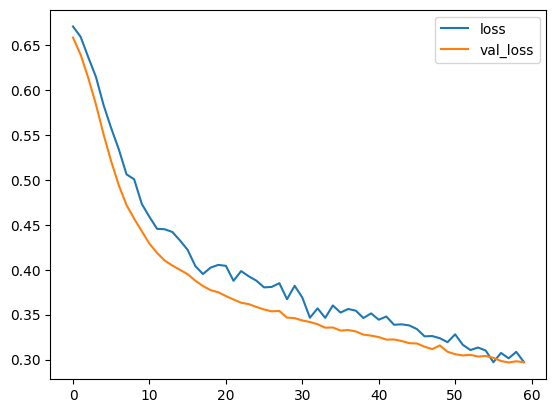

In [45]:
test_audio = []
test_labels = []

for audio, label in test_ds_processed:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

Test set accuracy: 94%


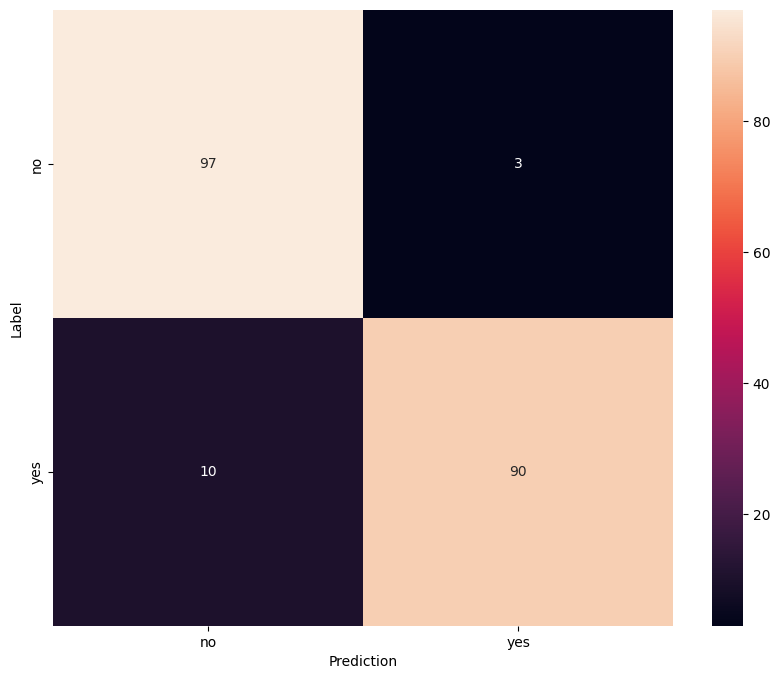

In [46]:
test_audio = []
test_labels = []

for audio, label in test_ds_processed:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## 9. 정수 양자화를 통한 TensorFlow Lite 변환

**중요:** `representative_dataset_gen` 함수는 TFLite 변환기가 요구하는 대로 각 샘플에 대해 배치 차원을 포함한 4D 텐서 `(1, 높이, 너비, 채널)`를 생성합니다.


In [47]:
def representative_dataset_gen():
    if tf.data.experimental.cardinality(train_ds_processed).numpy() == 0:
        print("경고: 훈련 세트가 비어 있어 대표 데이터셋 생성기가 실행될 수 없습니다. 더미 데이터를 생성합니다.")
        dummy_input = np.zeros((1, RESIZE_HEIGHT, RESIZE_WIDTH, 1), dtype=np.float32)
        yield [dummy_input]
        return
    take_count = min(100, tf.data.experimental.cardinality(train_ds_processed).numpy())
    for spectrogram_resized, _ in train_ds_processed.take(take_count):
        spectrogram_resized_4d = tf.expand_dims(spectrogram_resized, axis=0)
        yield [tf.cast(spectrogram_resized_4d, tf.float32)]


print("\nTensorFlow Lite 모델 변환 시도 중...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
model_tflite=converter.convert()
with open("audio_yesno_micro.tflite", "wb") as f:
    f.write(model_tflite)
print("✅ TFLite 모델 저장 완료: audio_yesno_micro.tflite")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model_quant = None
try:
    tflite_model_quant = converter.convert()
    print("TFLite 모델 변환 및 양자화 성공.")
    with open("audio_yesno_micro_q.tflite", "wb") as f:
        f.write(tflite_model_quant)
    print("✅ TFLite 모델 저장 완료: audio_yesno_micro_q.tflite")

except AttributeError as ae:
    print(f"TFLite 변환 실패 (AttributeError): {ae}")
    if "schema_py_generated" in str(ae) and "Model" in str(ae):
        print("이 오류는 TensorFlow Lite 설치 또는 버전 호환성 문제(예: TF 2.4.x)를 나타내는 경우가 많습니다.")
        print("TensorFlow가 올바르게 설치되었는지 확인하고 TF 2.5.0 이상으로 업그레이드하는 것을 고려해 보세요.")
        print("자세한 내용은 스크립트 시작 부분의 버전 확인 메시지를 참조하세요.")
    import traceback
    traceback.print_exc()
except Exception as e:
    print(f"TFLite 변환 중 예기치 않은 오류 발생: {e}")
    import traceback
    traceback.print_exc()



TensorFlow Lite 모델 변환 시도 중...
INFO:tensorflow:Assets written to: C:\Users\phant\AppData\Local\Temp\tmpqlaqrd0n\assets


INFO:tensorflow:Assets written to: C:\Users\phant\AppData\Local\Temp\tmpqlaqrd0n\assets


✅ TFLite 모델 저장 완료: audio_yesno_micro.tflite
INFO:tensorflow:Assets written to: C:\Users\phant\AppData\Local\Temp\tmp549ya_o7\assets


INFO:tensorflow:Assets written to: C:\Users\phant\AppData\Local\Temp\tmp549ya_o7\assets


TFLite 모델 변환 및 양자화 성공.
✅ TFLite 모델 저장 완료: audio_yesno_micro_q.tflite


## 10. 양자화된 TFLite 모델 저장 및 C 배열 생성

In [48]:
!xxd -i audio_yesno_micro_q.tflite > audio_yesno_micro_q.tflite.cpp
!type audio_yesno_micro_q.tflite.cpp

unsigned char audio_yesno_micro_q_tflite[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x4c, 0x00, 0x00, 0x00,
  0x00, 0x03, 0x00, 0x00, 0x10, 0x03, 0x00, 0x00, 0xa0, 0x0f, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00,
  0x08, 0x00, 0x00, 0x00, 0x11, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x13, 0x00, 0x00, 0x00, 0x6d, 0x69, 0x6e, 0x5f, 0x72, 0x75, 0x6e, 0x74,
  0x69, 0x6d, 0x65, 0x5f, 0x76, 0x65, 0x72, 0x73, 0x69, 0x6f, 0x6e, 0x00,
  0x12, 0x00, 0x00, 0x00, 0xb0, 0x02, 0x00, 0x00, 0xa8, 0x02, 0x00, 0x00,
  0x90, 0x02, 0x00, 0x00, 0x30, 0x02, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00,
  0xd0, 0x00, 0x00, 0x00, 0xb0, 0x00, 0x00, 0x00, 0x98, 0x00, 0x0